### Fire Speed Notebook
This is a cleaner and more complete version of fire_perims.ipynb

Including terrain distance and spot-checks translated from Nicole's R Code

In [5]:
### imports
### 'd2' python environment
import numpy as np
import geopandas as gpd
import shapely as sh
import matplotlib.pyplot as plt
import time
import math
import os
import rasterio
import shapely

In [6]:
### read fire data file
data = gpd.read_file("perim_data/east_troublesome_ts.gpkg")

In [93]:
### resample function -- need to take geometry and sample along boundary instead of inputs.
def resample_perim(perim, pts_per_meter):
    perim_len = perim.length
    n_samples = math.floor(pts_per_meter * perim_len)
    sampled = [perim.interpolate(i * perim_len / (n_samples - 1)) for i in range(n_samples)]
    if False:
        print(len(perim.coords), "-> resampled to ->", n_samples)
    return shapely.LinearRing(sampled)

### setup -- function to read raster elevation file...
def readraster(raster_loc, reproject_to=None):
    src = None
    if reproject_to is not None:
        os.system("gdalwarp -t_srs EPSG:" + str(reproject_to) + " -dstnodata -999 " + raster_loc + " " + 
                raster_loc[:-4] + "_" + str(reproject_to) + raster_loc[-4:])
        raster_loc = raster_loc[:-4] + "_" + str(reproject_to) + raster_loc[-4:]
        print("set raster loc to", raster_loc)
    return rasterio.open(raster_loc)

In [8]:
### fire distance computations
### direct (as crow flies) distance
def dist(a, b, params=None):
    return math.sqrt(((a[0] - b[0]) ** 2) + ((a[1] - b[1]) ** 2))

### terrain (arc length over ground) distance
def terraindist(a, b, distparams):
    terrain, steps_per_pix = distparams
    step_size = terrain.res[0]/steps_per_pix
    ### compute direct distance, use this to determine how many points to sample
    simple_dist = dist(a, b)
    n_samples = int(np.floor(simple_dist / step_size))
    ### check if the distance is long enough to sample, if so do that
    if n_samples > 0:
        ### regularly sample n_samples points between a and b
        ### my understanding is that the R code this is adapted from does NOT include
        ### the endpoints by default...

        ### . . ..  ### length = 5, step_size = 2 (0, 2, 4, (5))
        ### n_samples = floor(5/2) = 2
        ### regularly sample twice in the middle, once on each end...
        ### sample every s=(5/(2+1)) = 5/3... 0s, 1s, 2s, 3s, with n_samples+2 points

        total_dist = 0
        ### spatial steps
        vec_i = (b[0] - a[0]) / (n_samples+1)
        vec_j = (b[1] - a[1]) / (n_samples+1)
        ### sample elevations (more efficient to do all at once...?)
        elevs = list(elev_i[0] for elev_i in terrain.sample([(a[0] + vec_i * ii, a[1] + vec_j * ii) for ii in range(n_samples + 2)]))
        ### distance will be different than step_size due to regular sampling...
        step_dist = simple_dist/(n_samples+1)
        ### need to add the last point too! so n_samples+2 points
        for i in range(n_samples + 1):
            ### compute terrain distance with pythagorean theorem, step dist, elev. difference
            total_dist += math.sqrt((step_dist ** 2) + ((elevs[i+1] - elevs[i])**2))
        ### for bugfixing:
        if False:
            print(total_dist, simple_dist)
        return total_dist
    ### if not long enough to sample, only compare endpoints    
    else:
        ### sample elevations at start and endpoint
        elevs = list(elev_i[0] for elev_i in terrain.sample([a, b]))
        ### compute 3d-dist with horizontal, vertical differences
        total_dist = math.sqrt((simple_dist**2) + ((elevs[0] - elevs[1]) ** 2))
        return total_dist

In [ ]:
### distance computation 1 -- basic
### perim inner, outer are clean geometry
def nn_basic(perim_inner_geoms, perim_outer_geoms, inner_coords, inter_matrix, distfunc, resample, params):
    outer_coords = []

    result_dist = []
    result_coord_pair = []
    result_poly_pair = []
    ### perim_inner/outer geoms to be just gpd.iloc[i/i+1].geoms
    ### broadly, for points vi, vj and polys Px Py,
    ### minimize distances between vi and vj with i fixed (closest point to fixed point)
    ### maximize distances between vi and vjmax with vjmax the closest point to vi (furthest travelled between 2 polys)
    ### minimize distances between Px and Py with x fixed (closest polygon to the one looked at)
    ### maximize distances between Px and Pymax (furthest point from closest point on closest polygon)
    for poly_outer in range(len(perim_outer_geoms)):
        buffer_poly = perim_outer_geoms[poly_outer].buffer(params["buffer"])
        if resample is None: 
            outer = perim_outer_geoms[poly_outer].simplify(0.05).exterior.coords
        else:
            outer = resample(perim_outer_geoms[poly_outer].simplify(0.05).exterior, params["resample"]).coords
        outer_coords.append(outer)
        ### this checks if any previous perimeter is inside this one...
        ### if not, spotted
        spot_flag = not np.any(inter_matrix[:, poly_outer])
        polyids = []
        if spot_flag:
            ### in the R code, this is resampling to get more points per meter to get accurate estimate...?
            ### need to compare with all polygons
            polyids= [ii for ii in range(len(perim_inner_geoms))]
        ### if it hasn't spotted, compare to all perims that fall inside:
        else:
            for ii in range(len(perim_inner_geoms)):
                if inter_matrix[ii, poly_outer]:
                    polyids.append(ii)
        ### now, keep track of all comparisons for this polygon
        poly_min_dist = float("inf")
        poly_coordpair = None
        poly_pair = None

        for poly_inner in polyids:
            #inner = inner_coords[poly_inner]
            ### do distance...
            ### these keep track of shortest distance between outer_i and any inner_j
            step_pairs = [] ### step_n_1 point with minimum distance
            step_dists = []  ### distance to nearest step_n_1 point
            ### iterate over outer points
            for j in range(len(outer)):
                rolling_closest = None
                rolling_dist = float("inf")
                ### iterate over inner points to find closest
                for k in range(len(inner_coords[poly_inner])):
                    ### which is more expensive, computing whether this line exits the outer polygon
                    ### ... or terrain distance?
                    ### need to check if line between points goes out of bounds first... create line
                    ### check containment only if this polygon is not a spot...
                    if spot_flag or buffer_poly.contains(shapely.LineString([(inner_coords[poly_inner][k]), outer[j]])):
                        ### compute distance
                        tdist = distfunc(inner_coords[poly_inner][k], outer[j], params["dist"])
                        ### record if the distance is greater
                        if tdist < rolling_dist:
                            rolling_dist = tdist
                            rolling_closest = k
                step_pairs.append(rolling_closest)
                step_dists.append(rolling_dist)
            ### at this point we can compute the longest pair in this polygon combination...
            step_outer = np.argmax(step_dists)
            ### but really, we only want to save it if this represents the longest pair 
            ### ... between closest polygons
            if step_dists[step_outer] < poly_min_dist:
                poly_min_dist = step_dists[step_outer]
                if False:
                    print(poly_inner, step_pairs[step_outer], step_outer)
                poly_coordpair = [inner_coords[poly_inner][int(step_pairs[int(step_outer)])], outer[int(step_outer)]]
                poly_pair = (poly_inner, poly_outer)
        result_dist.append(poly_min_dist)
        result_coord_pair.append(poly_coordpair)
        result_poly_pair.append(poly_pair)
    max_loc = np.argmax(result_dist)
    return result_dist[max_loc], result_coord_pair[max_loc], result_poly_pair[max_loc], outer_coords

In [33]:
### distance computation 2 -- binned
### perim inner, outer are clean geometry
def nn_binned(perim_inner_geoms, perim_outer_geoms, inner_coords, inter_matrix, distfunc, resample, params):
    outer_coords = []

    ### does computing this beforehand speed things up? maybe a bit
    root2 = round(math.sqrt(2), 5)

    result_dist = []
    result_coord_pair = []
    result_poly_pair = []
    ### perim_inner/outer geoms to be just gpd.iloc[i/i+1].geoms
    ### broadly, for points vi, vj and polys Px Py,
    ### minimize distances between vi and vj with i fixed (closest point to fixed point)
    ### maximize distances between vi and vjmax with vjmax the closest point to vi (furthest travelled between 2 polys)
    ### minimize distances between Px and Py with x fixed (closest polygon to the one looked at)
    ### maximize distances between Px and Pymax (furthest point from closest point on closest polygon)
    for poly_outer in range(len(perim_outer_geoms)):
        buffer_poly = perim_outer_geoms[poly_outer].buffer(params["buffer"])
        ### computer poly_outer bounding box
        outer_bbox = perim_outer_geoms[poly_outer].exterior.bounds
        if resample is None: 
            outer = perim_outer_geoms[poly_outer].simplify(0.05).exterior.coords
        else:
            outer = resample(perim_outer_geoms[poly_outer].simplify(0.05).exterior, params["resample"]).coords
        outer_coords.append(outer)
        ### this checks if any previous perimeter is inside this one...
        ### if not, spotted
        spot_flag = not np.any(inter_matrix[:, poly_outer])
        polyids = []
        if spot_flag:
            ### in the R code, this is resampling to get more points per meter to get accurate estimate...?
            ### need to compare with all polygons
            polyids= [ii for ii in range(len(perim_inner_geoms))]
        ### if it hasn't spotted, compare to all perims that fall inside:
        else:
            for ii in range(len(perim_inner_geoms)):
                if inter_matrix[ii, poly_outer]:
                    polyids.append(ii)
        ### now, keep track of all comparisons for this polygon
        poly_min_dist = float("inf")
        poly_coordpair = None
        poly_pair = None

        for poly_inner in polyids:
            ### compute inner bounding box...
            inner_bbox = perim_inner_geoms[poly_inner].exterior.bounds
            ### compute combined bounding box
            bbox = (min(inner_bbox[0], outer_bbox[0]), min(inner_bbox[1], outer_bbox[1]), 
                    max(inner_bbox[2], outer_bbox[2]), max(inner_bbox[3], outer_bbox[3]))
            ### guess x, y bin sizes 
            bins_x = math.ceil((bbox[2] - bbox[0])/params["maxbins"])
            bins_y = math.ceil((bbox[3] - bbox[1])/params["maxbins"])
            ### bin resolution is bigger of these values since we want square bins
            bin_res = max(bins_x, bins_y)
            ### compute actual number of bins with bin resolution 
            grid_size = (math.ceil((bbox[2] - bbox[0])/bin_res), math.ceil((bbox[3] - bbox[1])/bin_res))
            grid_spatial = (grid_size[0] * bin_res, grid_size[1] * bin_res)
            grid_offset = ((grid_spatial[0] - (bbox[2] - bbox[0]))/2, (grid_spatial[1] - (bbox[3] - bbox[1]))/2)

            ### now make np array w/ coarser side...
            inner_bins = np.zeros(grid_size, dtype=object)
            inner_occu = np.zeros(grid_size, dtype=bool)
            outer_bins = np.zeros(grid_size, dtype=object)
            outer_occu = np.zeros(grid_size, dtype=bool)
            for i in range(grid_size[0]):
                for j in range(grid_size[1]):
                    inner_bins[i, j] = [] 
                    outer_bins[i, j] = []
            ### lower left of grid
            lower = (bbox[0] - grid_offset[0], bbox[1] - grid_offset[1])

            ### now, bin inner layer
            for i in range(len(inner_coords[poly_inner])):
                ### bin inner layer 
                inner_ids = (int((inner_coords[poly_inner][i][0]-lower[0])//bin_res), 
                           (int(inner_coords[poly_inner][i][1]-lower[1])//bin_res))
                inner_bins[inner_ids[0], inner_ids[1]].append(i)
                inner_occu[inner_ids[0], inner_ids[1]] = True
            ### now, bin outer layer
            for i in range(len(outer)):
                ### bin outer layer
                outer_ids = (int((outer[i][0]-lower[0])//bin_res), (int(outer[i][1]-lower[1])//bin_res))
                outer_bins[outer_ids[0], outer_ids[1]].append(i)
                outer_occu[outer_ids[0], outer_ids[1]] = True
            
            ### compute the list of ids of occupied outer bins...
            outer_where = np.argwhere(outer_occu == True) 

            sample_pair = None
            sample_dist = float("-inf")

            ### finally ... we can do binned nearest neighbors
            ### do root2 rings... focus on points in outer perim
            ### iterate over occupied bins in outer ring to narrow comparison
            for occu_loc in outer_where:
                ### start at the center bin and iteratively look further until we find all squares...
                ### withing 2sqrt(2) + slop of the closest point we find
                ### expand out until we find all squares with UL distance of 2sqrt(2) of the closest
                ### start with this loose upper bound because this is the furthest we can possibly iterate 
                ### ...because there are only so many bins...
                root2_dist = params["maxbins"] ### needs some work... to tighten upper bound?
                root2_set = True
                ring = 0
                ring_sqs = None
                ring_offset = None
                ### while the ring is within the upper bound
                while ring < root2_dist:
                    ### get shortlist of occupied bins (inner perim) within the ring
                    temp = np.argwhere(inner_occu[max(occu_loc[0]-ring, 0): min(occu_loc[0]+ring+1, grid_size[0] - 1), 
                                            max(occu_loc[1]-ring, 0): min(occu_loc[1]+ring+1, grid_size[1] - 1)]==True)
                    ### if there are occupied bins in this ring, and we haven't found an occupied bin yet, 
                    ### ... we can cap the number of rings with a loose-ish upper bound of the L1-distance
                    ### ... in which we could find a point with a smaller L2-distance
                    if len(temp) > 0 and root2_set:
                        ### if this is a spot we don't need to worry about bounds
                        if spot_flag:
                            root2_dist = math.ceil(root2 * (ring + 1)) + params["slop"]
                            root2_set = False
                        ### otherwise, need to actually check this combination stays within bounds 
                        ### ... before we know we have found a valid pair
                        else:
                            for k in range(len(outer_bins[occu_loc[0], occu_loc[1]])):
                                for i in range(len(temp)):
                                    temp_box = inner_bins[temp[i][0] + max(occu_loc[0]-ring, 0), 
                                                            temp[i][1] + max(occu_loc[1]-ring, 0)]
                                    for l in range(len(temp_box)):
                                        ## s1c[bins_1[occu_loc[0], occu_loc[1]][k]]
                                        if buffer_poly.contains(shapely.LineString([(inner_coords[poly_inner][temp_box[l]]),
                                                                                    outer[outer_bins[occu_loc[0], occu_loc[1]][k]]])):
                                            root2_dist = math.ceil(root2 * (ring + 1)) + params["slop"]
                                            root2_set = False
                                            break
                                    if not root2_set:
                                        break
                                if not root2_set:
                                    break
                    ### if we have reached the upper bound and have found points...
                    ### set nearest-neighbor-check shortlist to temp
                    if ring+1 >= root2_dist and not root2_set:
                        ring_sqs = temp
                        ### need to compute lower coords of ring... because temp locations are relative to this 
                        ring_offset = [max(occu_loc[0]-ring, 0), max(occu_loc[1]-ring, 0)]
                    ring += 1
                ### for each outer box (occu_loc) we have a series of points (len(bins_1[][])) -- 
                ###     for each point we have a series of inner boxes (ring_sqs[][][i/j])
                ###         for each inner box we have a series of points --- measure distances and find min
                spair = None
                sdist = float("-inf")
                n_checks = 0
                ### iterate over every point in this outer-perim bin
                for k in range(len(outer_bins[occu_loc[0], occu_loc[1]])):
                    tpair = None
                    tdist = float("inf")
                    ### iterate over every occupied bin found in the ring process..
                    for i in range(len(ring_sqs)):
                        ### get list of points from occupied bin i
                        inner_box = inner_bins[ring_sqs[i][0] + ring_offset[0], ring_sqs[i][1] + ring_offset[1]]
                        ### iterate over every point in this box
                        for l in range(len(inner_box)):
                            ### don't need to worry about bounds if we think its a spot...
                            if spot_flag or buffer_poly.contains(shapely.LineString([outer[outer_bins[occu_loc[0], occu_loc[1]][k]],
                                                                                     inner_coords[poly_inner][inner_box[l]]])):
                                ### we can NOW compare distances between every point in the central outer-perim bin and every
                                ### point in this inner-perim bin
                                ### distfunc(s1c[bins_1[occu_loc[0], occu_loc[1]][k]], s0c[temp_box_0[l]], distparams)
                                temp_dist = distfunc(outer[outer_bins[occu_loc[0], occu_loc[1]][k]], inner_coords[poly_inner][inner_box[l]], params["dist"])
                                ### check if we have found a new shortest pair...
                                ### this results in a shortest-pair combination for every point in this outer bin
                                if temp_dist < tdist:
                                    tpair = (inner_coords[poly_inner][inner_box[l]], outer[outer_bins[occu_loc[0], occu_loc[1]][k]])
                                    tdist = temp_dist
                            n_checks += 1
                    ### now having compared all inner samples to this point...
                    ### we can compare the shortest-pair distance we found to the other ones in this bin...
                    ### and hold on to the longest of them...
                    if tdist > sdist:
                        spair = tpair
                        sdist = tdist
                ### now we can compare the longest shortest-pair combo we found from this bin to the ones
                ### found in other bins...
                ### TODO -- some way to account for ties...
                if sdist > sample_dist:
                    sample_dist = sdist
                    sample_pair = spair
            ### at this point we have the furthest nearest-neighbor for this polygon pair
            if sample_dist < poly_min_dist:
                poly_min_dist = sample_dist
                poly_coordpair = sample_pair
                poly_pair = (poly_inner, poly_outer)
        ### aggregate over all outer polygons
        result_dist.append(poly_min_dist)
        result_coord_pair.append(poly_coordpair)
        result_poly_pair.append(poly_pair)
    max_loc = np.argmax(result_dist)
    return result_dist[max_loc], result_coord_pair[max_loc], result_poly_pair[max_loc], outer_coords


In [35]:
### broadly, for each time step, want to find the nearest point in A to every point in B
### ... then find the maximum distance d(Ai, Bj)
### ... with multiple perims (spotting?) we need to make sure 
### ... to find the furthest combination of the above between nearest polygons...

def nn_firespeed(gpd_data, stopat, nnfunc, distfunc, resample, params):
    result_time = [] ### time taken to compute each step
    result_pair = [] ### pair of points with max min distance
    result_poly = [] ### pair of polygons with max min dist
    result_dist = [] ### distance between points

    ### start timer
    time_1 = time.time()

    ### get original inner perimeter and simplify geometry with tolerance 0.05
    ### make sure to get all polygons within multipolygon for spotting!
    if resample is None:
        prev_step = [gpd_data.iloc[0]["geometry"].geoms[ii].simplify(0.05).exterior.coords for ii in range(len(gpd_data.iloc[0]["geometry"].geoms))]
    if resample is not None:
        prev_step = [resample(gpd_data.iloc[0]["geometry"].geoms[ii].simplify(0.05).exterior, params["resample"]).coords for ii in range(len(gpd_data.iloc[0]["geometry"].geoms))]
    ### iterate over time steps
    for i in range(1, min(gpd_data.shape[0], stopat)):
        ### progress update
        if i % params["updatefreq"] == 0:
            print("simplified", i)
        
        ### setup for overlap and spot checks...
        inter_matrix = np.zeros((len(gpd_data.iloc[i-1]["geometry"].geoms), len(gpd_data.iloc[i]["geometry"].geoms)))
        for ii in range(inter_matrix.shape[0]):
            for jj in range(inter_matrix.shape[1]):
                inter_matrix[ii, jj] = gpd_data.iloc[i-1]["geometry"].geoms[ii].intersects(gpd_data.iloc[i]["geometry"].geoms[jj])
        ### bug check
        if inter_matrix.shape[0] == 1 and inter_matrix.shape[1] == 1 and inter_matrix[0, 0] == False:
            print("uh oh: no overlap!", i)

        ###nn_basic(perim_inner_geoms, perim_outer_geoms, inner_coords, inter_matrix, distfunc, resample, params)
        sdist, scoordpair, spolypair, prev_step = nnfunc(gpd_data.iloc[i-1]["geometry"].geoms, gpd_data.iloc[i]["geometry"].geoms, prev_step, inter_matrix,
                                              distfunc, resample, params)
        
        result_pair.append(scoordpair)
        result_poly.append(spolypair)
        result_dist.append(sdist)
        time_0 = time_1
        time_1 = time.time()
        result_time.append(time_1 - time_0)
    return result_pair, result_dist, result_poly, result_time



In [14]:
### set up experiments!
### load raster
elev_data = readraster("R_fire_speed/LC20_Elev_220_estes_park.tif", 32613)


Using internal nodata values (e.g. 32767) for image R_fire_speed/LC20_Elev_220_estes_park.tif.
Processing R_fire_speed/LC20_Elev_220_estes_park.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
set raster loc to R_fire_speed/LC20_Elev_220_estes_park_32613.tif


In [ ]:
basic_run = 10
### params for basic nn computation, elevation distance
basic_params = {"resample": 0.05,
                "dist": [elev_data, 1],
                "buffer": 200,
                "updatefreq": basic_run // 10}

run_basic = nn_firespeed(data, basic_run, nn_basic, terraindist, resample_perim, basic_params)

259 -> resampled to -> 125
[[1.]]
466 -> resampled to -> 227
0 69 123
[[1.]]
554 -> resampled to -> 269
0 123 143
[[1.]]
694 -> resampled to -> 341
0 143 179
[[1.]]
836 -> resampled to -> 413
0 179 223
[[1.]]
978 -> resampled to -> 479
0 221 257
[[1.]]
1141 -> resampled to -> 557
0 238 259
[[1.]]
1256 -> resampled to -> 612
0 300 326
[[1.]]
1380 -> resampled to -> 673
0 327 366
[[1.]]
1464 -> resampled to -> 715
0 368 394


In [61]:
binned_run = 30
### params for basic nn computation, elevation distance
binned_params = {"resample": 0.05,
                "dist": [elev_data, 1],
                "buffer": 200,
                "updatefreq": binned_run // 10,
                "maxbins": 200,
                "slop": 2}

run_binned = nn_firespeed(data, binned_run, nn_binned, terraindist, resample_perim, binned_params)

259 -> resampled to -> 125
466 -> resampled to -> 227
554 -> resampled to -> 269
simplified 3
694 -> resampled to -> 341
836 -> resampled to -> 413
978 -> resampled to -> 479
simplified 6
1141 -> resampled to -> 557
1256 -> resampled to -> 612
1380 -> resampled to -> 673
simplified 9
1464 -> resampled to -> 715
1563 -> resampled to -> 765
1680 -> resampled to -> 821
simplified 12
1803 -> resampled to -> 882
1991 -> resampled to -> 976
2182 -> resampled to -> 1056
simplified 15
2313 -> resampled to -> 1121
2513 -> resampled to -> 1213
2731 -> resampled to -> 1326
simplified 18
2822 -> resampled to -> 1381
2938 -> resampled to -> 1437
3138 -> resampled to -> 1534
simplified 21
3387 -> resampled to -> 1656
3610 -> resampled to -> 1787
3874 -> resampled to -> 1917
simplified 24
3615 -> resampled to -> 1820
3797 -> resampled to -> 1908
4088 -> resampled to -> 2078
simplified 27
4359 -> resampled to -> 2208
4505 -> resampled to -> 2281
4702 -> resampled to -> 2403


In [49]:
print(run_basic[0])
print(run_binned[0])

[[(439373.1117031962, 4466003.935604062), (440015.73490419716, 4466134.212023422)], [(440015.73490419716, 4466134.212023422), (440295.02041577327, 4466207.406034434)], [(440295.02041577327, 4466207.406034434), (440712.9701603906, 4466290.568476907)], [(440712.9701603906, 4466290.568476907), (441159.20502733946, 4466345.7525896765)], [(441155.2864846565, 4466381.667188261), (441577.3513220056, 4466461.302496087)], [(441328.32184296416, 4466595.361064566), (441644.8427168527, 4466932.453026898)], [(442048.7690776137, 4466512.779720221), (442494.2015132576, 4466649.941741125)], [(442496.98847419326, 4466632.665588468), (442942.7638519716, 4466621.280864863)], [(442941.6892166277, 4466581.648937965), (443331.7477651356, 4466564.677128359)]]
[((439373.1117031962, 4466003.935604062), (440015.73490419716, 4466134.212023422)), ((440015.73490419716, 4466134.212023422), (440295.02041577327, 4466207.406034434)), ((440295.02041577327, 4466207.406034434), (440712.9701603906, 4466290.568476907)), ((

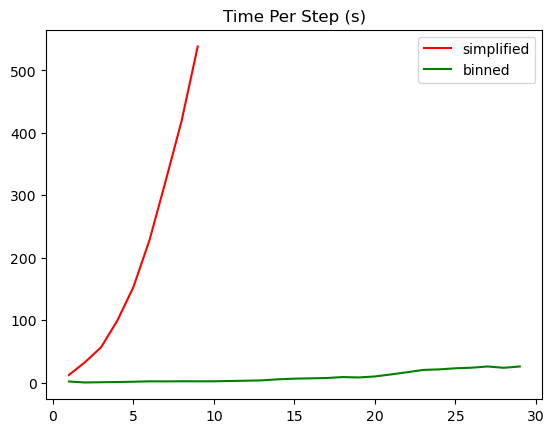

In [89]:
### check one -- compare times...
fig, axs = plt.subplots()
itersteps_basic = np.arange(len(run_basic[3])) + 1
itersteps_binned = np.arange(len(run_binned[3])) + 1
axs.plot(itersteps_basic, run_basic[3], color="red", label="simplified")
axs.plot(itersteps_binned, run_binned[3], color="green", label="binned")
axs.legend()

plt.title("Time Per Step (s)")
plt.show()

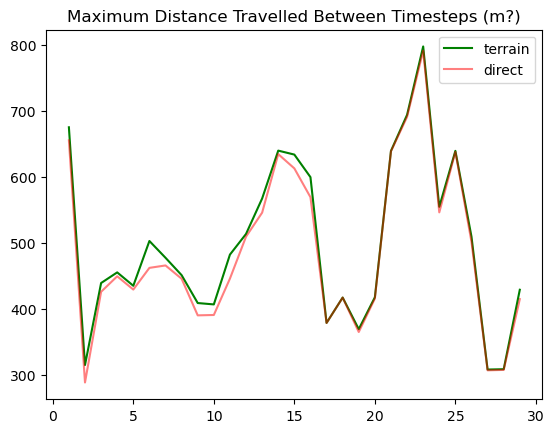

In [96]:
### Check out distances over time...
### distances from run_binned are terrain distances, but we can also compute simple distances
simple_dists = []
for i in range(len(run_binned[0])):
    simple_dists.append(dist(run_binned[0][i][0], run_binned[0][i][1]))

fig, axs = plt.subplots()
itersteps_binned = np.arange(len(run_binned[1])) + 1
axs.plot(itersteps_binned, run_binned[1], color="green", label="terrain")
axs.plot(itersteps_binned, simple_dists, color="red", alpha=0.5, label="direct")
axs.legend()

plt.title("Maximum Distance Travelled Between Timesteps (m?)")
plt.show()

Text(0.5, 1.0, 'Binned NN Method')

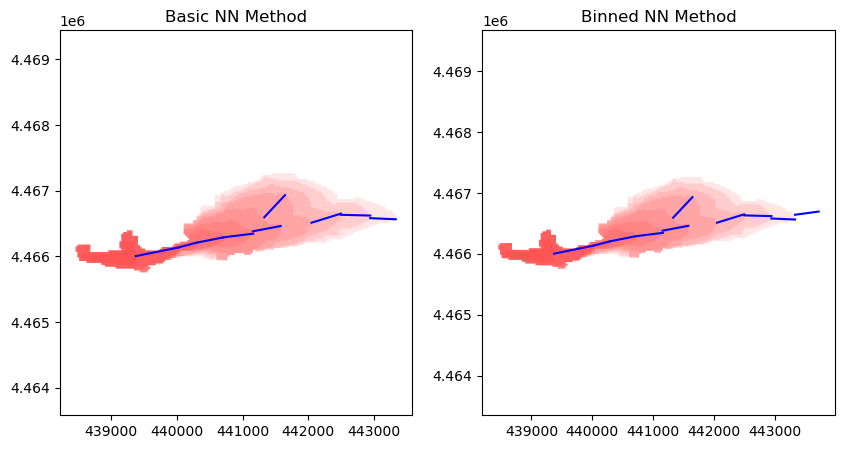

In [81]:
### check two -- compare results...
### this check is to make sure both algorithms are doing the same thing...
upto = 10
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_aspect('equal', 'datalim')
axs[1].set_aspect('equal', 'datalim')
for i in range(upto):
    xsi, ysi = data.iloc[i]["geometry"].geoms[0].simplify(0.05).exterior.xy
    axs[0].fill(xsi, ysi, alpha=0.1, fc='r', ec='none')
    if i < len(run_basic[0]):
        axs[0].plot([run_basic[0][i][0][0], run_basic[0][i][1][0]], 
                    [run_basic[0][i][0][1], run_basic[0][i][1][1]], color="blue")
for i in range(upto):
    xsi, ysi = data.iloc[i]["geometry"].geoms[0].simplify(0.05).exterior.xy
    axs[1].fill(xsi, ysi, alpha=0.1, fc='r', ec='none')
    if i < len(run_binned[0]):
        axs[1].plot([run_binned[0][i][0][0], run_binned[0][i][1][0]], 
                    [run_binned[0][i][0][1], run_binned[0][i][1][1]], color="blue")
        
axs[0].set_title("Basic NN Method")
axs[1].set_title("Binned NN Method")


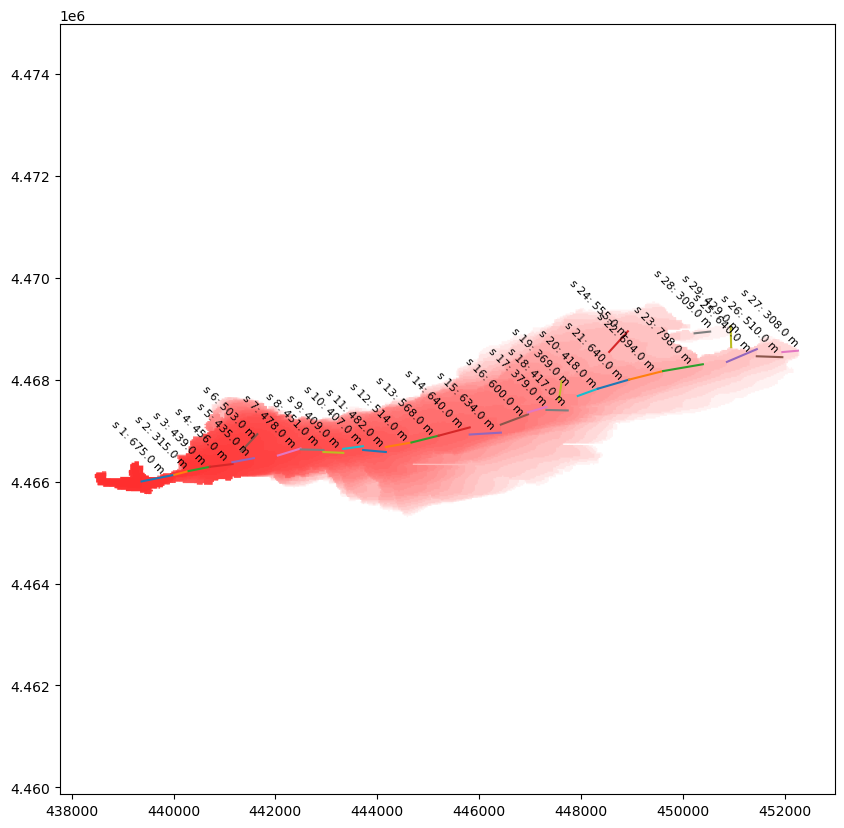

In [92]:
### longer look at just the binned one...
fig, axs = plt.subplots(figsize=(10, 10))
axs.set_aspect('equal', 'datalim')
for i in range(binned_run):
    xsi, ysi = data.iloc[i]["geometry"].geoms[0].simplify(0.05).exterior.xy
    axs.fill(xsi, ysi, alpha=0.05, fc='r', ec='none')
    if i < len(run_binned[0]):
        axs.plot([run_binned[0][i][0][0], run_binned[0][i][1][0]], 
                 [run_binned[0][i][0][1], run_binned[0][i][1][1]]) #, color="blue")
        mid_x = (run_binned[0][i][0][0] + run_binned[0][i][1][0]) / 2
        mid_y = (run_binned[0][i][0][1] + run_binned[0][i][1][1]) / 2
    
        # Add text above the midpoint of the line
        axs.text(mid_x - 400, mid_y + 100, 
                 "s " + str(i+1) + ": " + str(round(run_binned[1][i], 0)) + " m", 
                 fontsize=8, ha='center', rotation=-45)


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs[0].set_aspect('equal', 'datalim')

pton = 10

xsi1, ysi1 = data.iloc[pton]["geometry"].geoms[0].simplify(0.05).exterior.xy
axs[0].fill(xsi1, ysi1, alpha=0.1, fc='r', ec='none')

xsi2, ysi2 = data.iloc[pton+1]["geometry"].geoms[0].simplify(0.05).exterior.xy
axs[0].fill(xsi2, ysi2, alpha=0.1, fc='r', ec='none')